# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)
#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style 
import matplotlib as mpl


#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#For debugging problems
print(tf.__version__)

2.3.0


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

In [4]:
model=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model.add(keras.layers.Conv2D(128,5,input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down reduces image size  27*27 -> 9*9

model.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down reduces image size  9*9 -> 3*3

model.add(keras.layers.Conv2D(1,3,activation="relu",padding='same'))     # 9 neuron layer
model.add(keras.layers.UpSampling2D(size=(3,3)))                         # up increases image size 3*3 -> 9*9

model.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))                         # up increases image size 9*9 -> 3*3

model.add(keras.layers.Conv2D(128,5,activation="relu",padding='same'))

model.add(keras.layers.Conv2D(256,5,activation="relu",padding='same'))   # last layer 

model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   3328      
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     577       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 1)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    1

Final cost: 0.0075


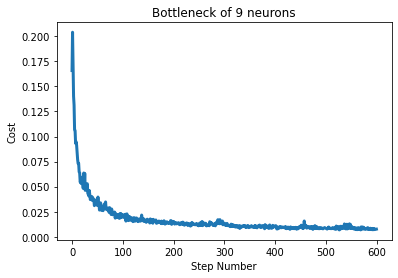

In [5]:
# Now we can do the actual model training
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=50,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title("Bottleneck of 9 neurons")
print('Final cost: {}'.format(round(cost[-1],4)))

In [6]:
print_layers(model,y_target)

Layer 0: 93312 neurons /  (50, 27, 27, 128)
Layer 1: 10368 neurons /  (50, 9, 9, 128)
Layer 2: 5184 neurons /  (50, 9, 9, 64)
Layer 3: 576 neurons /  (50, 3, 3, 64)
Layer 4: 9 neurons /  (50, 3, 3, 1)
Layer 5: 81 neurons /  (50, 9, 9, 1)
Layer 6: 5184 neurons /  (50, 9, 9, 64)
Layer 7: 46656 neurons /  (50, 27, 27, 64)
Layer 8: 93312 neurons /  (50, 27, 27, 128)
Layer 9: 186624 neurons /  (50, 27, 27, 256)


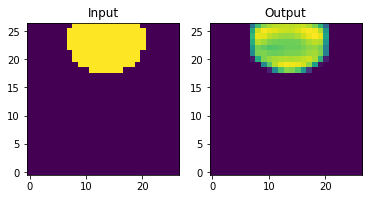

In [7]:
plot_test_image(model,circle_generator,27)

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



In [8]:
model2=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model2.add(keras.layers.Conv2D(128,5,input_shape=(None,None,1),activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down reduces image size  27*27 -> 9*9

model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down reduces image size  9*9 -> 3*3

model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down reduces image size  3*3 -> 1*1


model2.add(keras.layers.Conv2D(3,3,activation="relu",padding='same'))     # 3 neuron layer
model2.add(keras.layers.UpSampling2D(size=(3,3)))                         # up increases image size 1*1 -> 3*3

model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3)))                         # up increases image size 3*3 -> 9*9

model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3)))                         # up increases image size 9*9 -> 27*27

model2.add(keras.layers.Conv2D(128,5,activation="relu",padding='same')) 

model2.add(keras.layers.Conv2D(512,5,activation="linear",padding='same')) #last layer

model2.compile(loss='mean_squared_error',
              optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 128)   3328      
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 128)   0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
average_pooling2d_3 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    102464    
_________________________________________________________________
average_pooling2d_4 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 3)    

Final cost: 0.1435


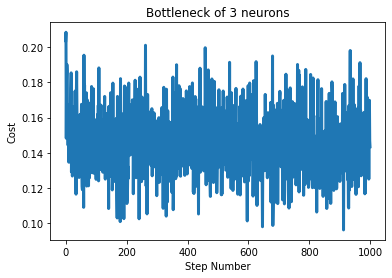

In [9]:
# Now we can do the actual model training
steps=1000
cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title("Bottleneck of 3 neurons")
print('Final cost: {}'.format(round(cost[-1],4)))

In [10]:
print_layers(model2,y_target)

Layer 0: 93312 neurons /  (30, 27, 27, 128)
Layer 1: 10368 neurons /  (30, 9, 9, 128)
Layer 2: 5184 neurons /  (30, 9, 9, 64)
Layer 3: 576 neurons /  (30, 3, 3, 64)
Layer 4: 576 neurons /  (30, 3, 3, 64)
Layer 5: 64 neurons /  (30, 1, 1, 64)
Layer 6: 3 neurons /  (30, 1, 1, 3)
Layer 7: 27 neurons /  (30, 3, 3, 3)
Layer 8: 576 neurons /  (30, 3, 3, 64)
Layer 9: 5184 neurons /  (30, 9, 9, 64)
Layer 10: 5184 neurons /  (30, 9, 9, 64)
Layer 11: 46656 neurons /  (30, 27, 27, 64)
Layer 12: 93312 neurons /  (30, 27, 27, 128)
Layer 13: 373248 neurons /  (30, 27, 27, 512)


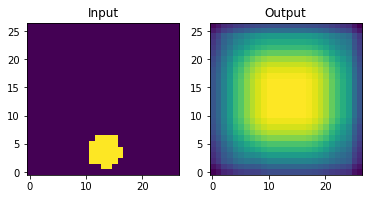

In [11]:
plot_test_image(model2,circle_generator,27)

In [12]:
l = 20
fcost = np.zeros(l)
steps=1000
for i in range(l):
    model2=keras.models.Sequential()
    
    model2.add(keras.layers.Conv2D(128,5,input_shape=(None,None,1),activation="relu",padding='same'))
    # down reduces image size  27*27 -> 9*9
    model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

    model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
    # down reduces image size  9*9 -> 3*3
    model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

    model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
    # down reduces image size  3*3 -> 1*1
    model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) 


    model2.add(keras.layers.Conv2D(3,3,activation="relu",padding='same'))     # 3 neuron layer
    # up increases image size 1*1 -> 3*3
    model2.add(keras.layers.UpSampling2D(size=(3,3)))                         

    model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
    # up increases image size 3*3 -> 9*9
    model2.add(keras.layers.UpSampling2D(size=(3,3)))                         

    model2.add(keras.layers.Conv2D(64,5,activation="relu",padding='same'))
    # up increases image size 9*9 -> 27*27
    model2.add(keras.layers.UpSampling2D(size=(3,3)))                         

    model2.add(keras.layers.Conv2D(128,5,activation="relu",padding='same')) 

    model2.add(keras.layers.Conv2D(512,5,activation="linear",padding='same')) #last layer

    model2.compile(loss='mean_squared_error',
              optimizer='adam')
    cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=steps)
    fcost[i]= cost[-1]
    print(i+1,'out of',l)


1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


In [14]:
print('Final Cost Values:',fcost)

Final Cost Values: [0.03207168 0.11609237 0.04987256 0.07695428 0.03730131 0.04911431
 0.01060012 0.00944711 0.05350025 0.00953344 0.01103466 0.01117383
 0.05130559 0.04725001 0.00733441 0.0501614  0.0350532  0.00680855
 0.00769743 0.01045305]


In [15]:
av = np.average(fcost)

Text(0.5, 1.0, 'Final Cost Of Each Iteration')

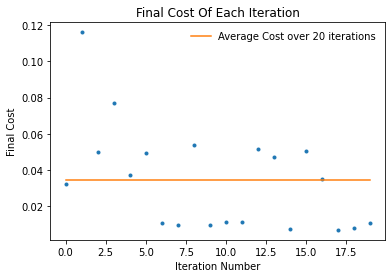

In [16]:
plt.plot(fcost,'.')
plt.plot(np.arange(l),np.ones(l)*av,label='Average Cost over {} iterations'.format(l))
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('Final Cost')
plt.title('Final Cost Of Each Iteration')

For the network with a bottleneck of 9 neurons I found to be quite consistent so didn't require the need of an average over multiple iterations. Whilst the bottleneck of 9 would consistently have a final cost of bellow 0.01 on the other hand the bottleneck of 3 I found to vary a fair amount. Multiple final cost values bellow 0.01 then a similar amount in the range of 0.01 and 0.05 but with a few around 0.1 or higher. So I found that the bottleneck of 3 neurons was not reliable enough to consistently produce good enough images.